In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import islice
from lib import models
from lib.nyt_connections import get_connections_games, get_connections_tasks
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.tokenize import TaskResultTokenizer
from lib.tune import tune
from lib.vllm import start_vllm, kill_vllm_workers
import torch
from transformers import AutoTokenizer

games = get_connections_games()
tasks = list(
    islice(get_connections_tasks(games, parse_answers_liberally=False), len(games) * 2)
)
distill_tasks = tasks[:436]
val_tasks = tasks[436:508]
test_tasks = tasks[508 : len(games)]
train_tasks = tasks[len(games) : len(games) + 436]
len(distill_tasks), len(val_tasks), len(test_tasks), len(train_tasks)

(436, 72, 92, 436)

In [21]:
model = models.qwen_7b() 
tokenizer = AutoTokenizer.from_pretrained(model.base_model)

vllm = await start_vllm(
    model.base_model,
    max_concurrent_requests=512,
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=512,
        max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=120 + 15 * torch.cuda.device_count(),
)

$ vllm serve deepseek-ai/DeepSeek-R1-Distill-Qwen-7B --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --port=8000 --api-key=default
INFO 02-18 22:06:00 __init__.py:190] Automatically detected platform cuda.
INFO 02-18 22:06:01 api_server.py:840] vLLM API server version 0.7.2
INFO 02-18 22:06:01 api_server.py:841] args: Namespace(subparser='serve', model_tag='deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role='assistant', ssl_keyfile=None, ssl_certfile=None, ssl_ca_certs=N

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  50% Completed | 1/2 [00:00<00:00,  1.11it/s]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.10s/it]
Loading safetensors checkpoint shards: 100% Completed | 2/2 [00:02<00:00,  1.07s/it]



INFO 02-18 22:06:13 model_runner.py:1115] Loading model weights took 14.2717 GB
INFO 02-18 22:06:14 worker.py:267] Memory profiling takes 0.73 seconds
INFO 02-18 22:06:14 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-18 22:06:14 worker.py:267] model weights take 14.27GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 2.90GiB; the rest of the memory reserved for KV Cache is 57.82GiB.
INFO 02-18 22:06:14 executor_base.py:110] # CUDA blocks: 33833, # CPU blocks: 46811
INFO 02-18 22:06:14 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 66.08x
INFO 02-18 22:06:52 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 38.82 seconds
INFO 02-18 22:06:53 api_server.py:756] Using supplied chat template:
INFO 02-18 22:06:53 api_server.py:756] None
INFO 02-18 22:06:53 launcher.py:21] Available routes are:
INFO 02-18 22:06:53 launcher.py:29] Route: /

INFO:     Started server process [18994]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-18 22:06:53 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45176 - "POST /v1/chat/completions HTTP/1.1" 200 OK


Exception ignored in: <function vLLM.__del__ at 0x78388dbd2480>
Traceback (most recent call last):
  File "/home/ubuntu/sky_workdir/experiments/lib/vllm.py", line 21, in __del__
    self.process.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/subprocess.py", line 143, in terminate
    self._transport.terminate()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 149, in terminate
    self._check_proc()
  File "/home/ubuntu/.local/share/uv/python/cpython-3.12.9-linux-x86_64-gnu/lib/python3.12/asyncio/base_subprocess.py", line 142, in _check_proc
    raise ProcessLookupError()
ProcessLookupError: 


vLLM server started succesfully. Logs can be found at ./logs/vllm.log


In [34]:
tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id)

'<｜end▁of▁sentence｜>'

In [33]:
TaskResultTokenizer(tokenizer)

AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True)

In [38]:
tokenizer

LlamaTokenizerFast(name_or_path='deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', vocab_size=151643, model_max_length=16384, is_fast=True, padding_side='left', truncation_side='right', special_tokens={'bos_token': '<｜begin▁of▁sentence｜>', 'eos_token': '<｜end▁of▁sentence｜>', 'pad_token': '<｜end▁of▁sentence｜>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	151643: AddedToken("<｜end▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151644: AddedToken("<｜User｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151645: AddedToken("<｜Assistant｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151646: AddedToken("<｜begin▁of▁sentence｜>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	151647: AddedToken("<|EOT|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	151648: AddedToken("<think>", rstrip=False, 

In [53]:
tokenized_results = [
    result
    for results in await get_task_results(
        tasks=train_tasks[: 512 // 16],
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=8,
        n=16,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
        ),
        semaphore=asyncio.Semaphore(vllm.max_concurrent_tokens // 3300),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]

  0%|          | 0/512 [00:00<?, ?it/s]

Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping
Result is too long, skipping


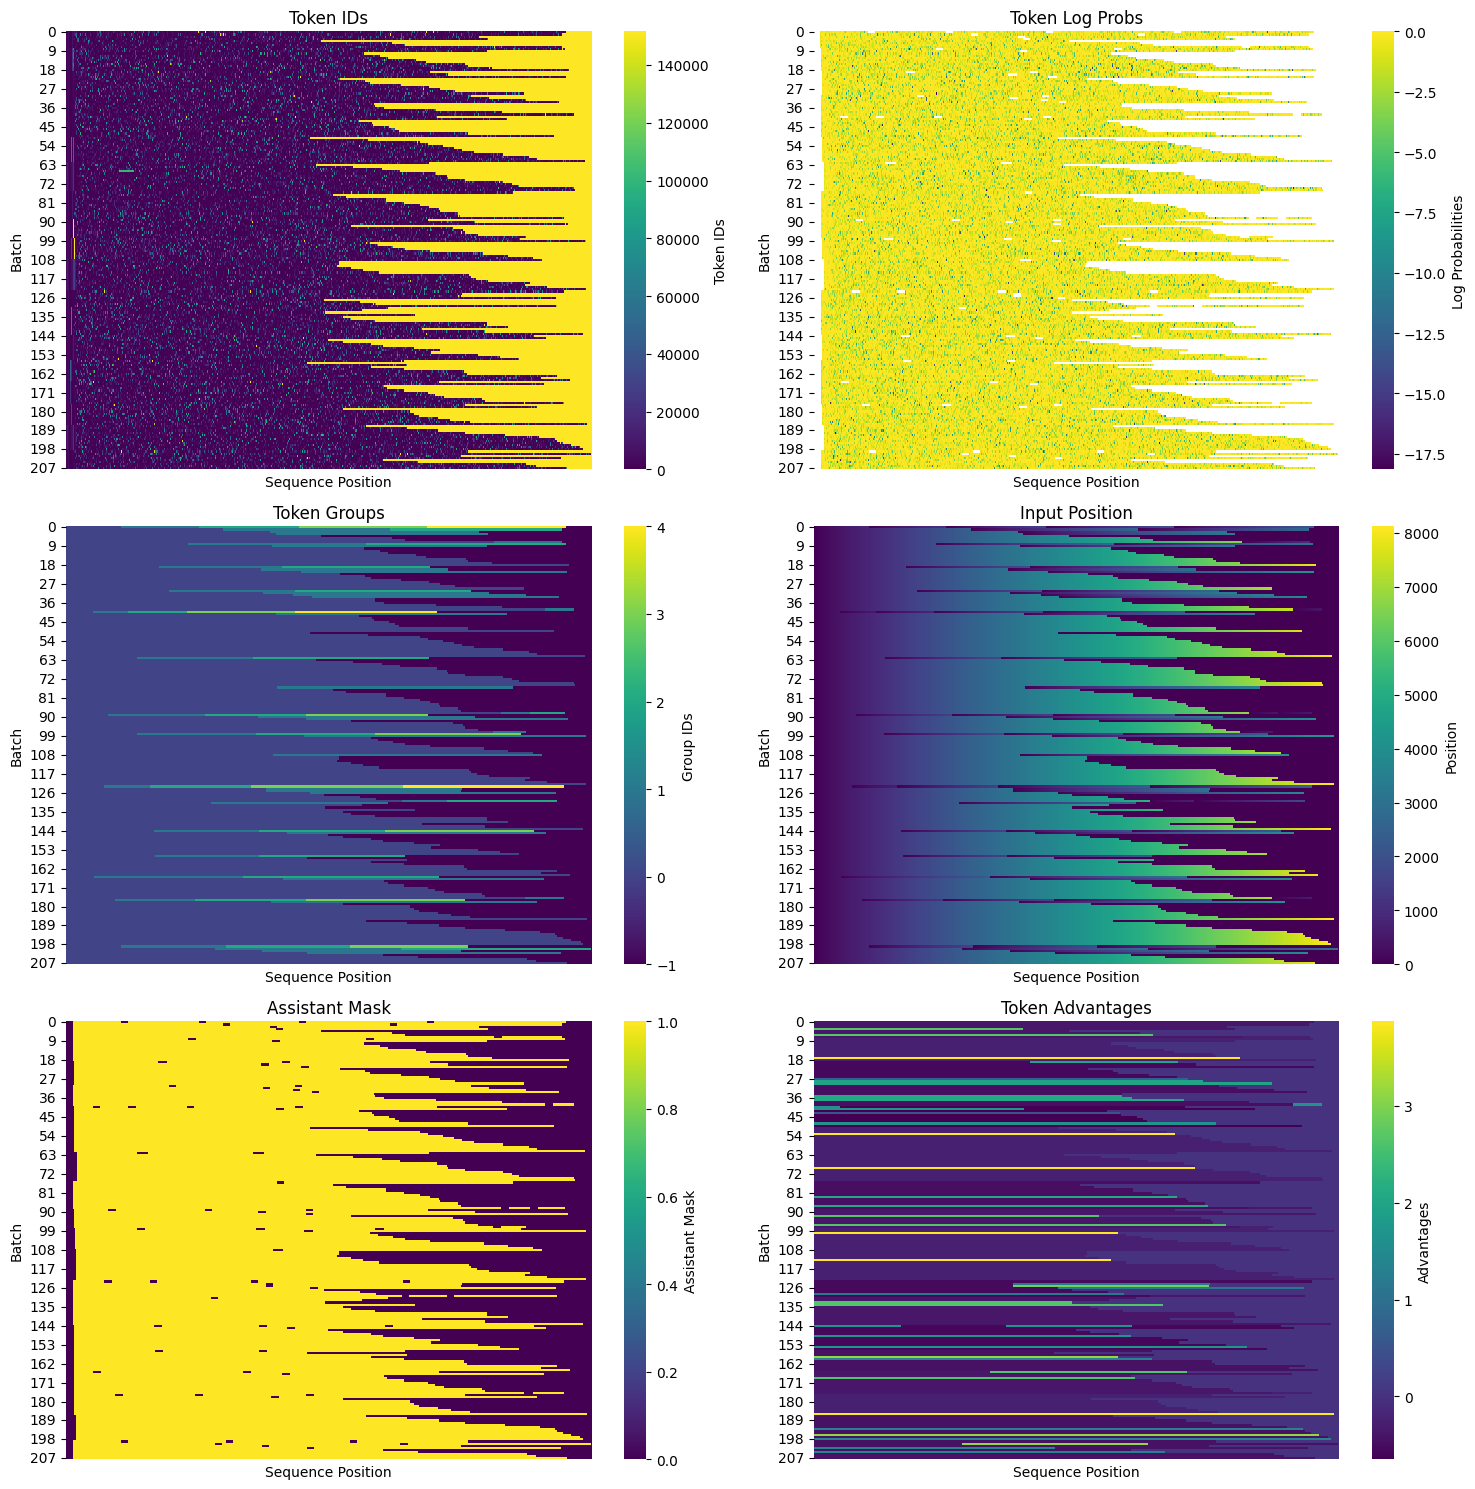

{'tokens': tensor([[151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   9885,  ..., 151643, 151643, 151643],
         ...,
         [151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   9885,  ..., 151643, 151643, 151643],
         [151646, 151644,   9885,  ..., 151643, 151643, 151643]]),
 'group_ids': tensor([[ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         ...,
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1],
         [ 0,  0,  0,  ..., -1, -1, -1]]),
 'input_pos': tensor([[0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         ...,
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0],
         [0, 1, 2,  ..., 0, 0, 0]]),
 'assistant_mask': tensor([[False, False, False,  ..., False, False, F

In [54]:
seq_len = 8192
packed_tensors = packed_tensors_from_tokenized_results(
    [result for result in tokenized_results if result.advantage != 0],
    seq_len=seq_len,
    pad_token_id=tokenizer.pad_token_id,  # type: ignore
)
plot_packed_tensors(packed_tensors)
packed_tensors

In [55]:
from lib.grpo import GRPO

result = GRPO(entropy_coef=1.0, kl_coef=1.0)._forward_chunk(
    logits=torch.tensor([[[0.0, -1.0], [0.0, 0.0]]]),
    tokens=torch.tensor([[1, 1]]),
    advantages=torch.tensor([[-1.0, -1.0]]),
    logprobs=torch.tensor([[-0.6931, -0.6931]]),
    reference_logprobs=torch.tensor([[-0.6931, -0.6931]]),
    # reference_logprobs=torch.tensor([[float("nan"), float("nan")]]),
    mask=torch.tensor([[True, True]]),
    bos_id=0,
)
display(result)
result.total_loss

GRPOResult(num_tokens=tensor(1), policy_loss=tensor(0.8000), entropy=tensor(0.5822), kl_div=tensor(0.3101), entropy_weight=tensor(1.), kl_weight=tensor(1.))

tensor(0.5279)

In [81]:
model.tune_max_batch_tokens = 32_768
model.tune_fsdp_cpu_offload = True
# model.tune_optimizer = "bitsandbytes.optim.PagedAdamW8bit"
model.tune_optimizer = "torch.optim.AdamW"

In [ ]:
optimizer_config = ComponentConfig(model.tune_optimizer, lr=2e-5)
if model.tune_optimizer == "torch.optim.AdamW":
    optimizer_config.fused = True

distilled_model = await tune(
    base_model=model.base_model,
    output_dir="./models/rl1",
    packed_tensors=packed_tensors,
    model=model.tune_model,
    model_type=model.tune_model_type,
    config=TuneRecipeConfig(
        optimizer=optimizer_config,
        batch_size=model.tune_max_batch_tokens // seq_len,
        fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
        enable_activation_checkpointing=True,
        enable_activation_offloading=True,
        custom_sharded_layers=["tok_embeddings", "output"],
        num_output_chunks=8,
    ),
)

$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/rl1/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 4
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247
  checkpoint_files:
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00002-of-000002.safetensors
  - /home/ubuntu/.cache/huggingface/hub/models--deepseek-ai--DeepSeek-R1-Distill-Qwen-7B/snapshots/6602cadec947dbb53e64f3d8d6425320b2197247/model-00001-of-000002.safetensors
  model_type: QWEN2
  output_dir: ./models/rl1
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/rl1/tensors
  num_seque

Writing logs to models/rl1/logs/log_1739922642.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 30.06 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 5.53 GiB
	GPU peak memory reserved: 5.75 GiB
	GPU peak memory active: 5.53 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|36|Loss: 0.5854:  69%|██████▉   | 36/52 [09:56<04:19, 16.24s/it, entropy=2.78, kl_div=0.511, loss=0.585, lr=2e-5, policy=0.585]   

In [13]:
vllm = await start_vllm(
    distilled_model,
    # env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
    max_concurrent_requests=512,
    named_arguments=dict(
        block_size=32,
        disable_log_requests=True,
        # enable_chunked_prefill=True,
        enable_prefix_caching=True,
        enforce_eager=True,
        gpu_memory_utilization=0.95,
        max_model_len=16384,
        max_num_seqs=512,
        max_num_batched_tokens=16384,
        num_scheduler_steps=8,
        preemption_mode="swap",
        return_tokens_as_token_ids=True,
        swap_space=80,
        tensor_parallel_size=torch.cuda.device_count(),
    ),
    timeout=120 + 15 * torch.cuda.device_count(),
)
vllm

$ vllm serve /home/gcpuser/sky_workdir/experiments/models/rl1/0001 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=512 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=8 --served-model-name=./models/rl1/0001 --port=8000 --api-key=default
INFO 02-18 18:05:44 __init__.py:190] Automatically detected platform cuda.
INFO 02-18 18:05:45 api_server.py:840] vLLM API server version 0.7.2
INFO 02-18 18:05:45 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/gcpuser/sky_workdir/experiments/models/rl1/0001', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_rol

Loading pt checkpoint shards:   0% Completed | 0/17 [00:00<?, ?it/s]
Loading pt checkpoint shards:   6% Completed | 1/17 [00:05<01:33,  5.87s/it]
Loading pt checkpoint shards:  12% Completed | 2/17 [00:11<01:21,  5.44s/it]
Loading pt checkpoint shards:  18% Completed | 3/17 [00:11<00:47,  3.37s/it]
Loading pt checkpoint shards:  24% Completed | 4/17 [00:17<00:53,  4.10s/it]
Loading pt checkpoint shards:  29% Completed | 5/17 [00:22<00:52,  4.42s/it]
Loading pt checkpoint shards:  35% Completed | 6/17 [00:27<00:51,  4.69s/it]
Loading pt checkpoint shards:  41% Completed | 7/17 [00:32<00:48,  4.86s/it]
Loading pt checkpoint shards:  47% Completed | 8/17 [00:37<00:44,  5.00s/it]
Loading pt checkpoint shards:  53% Completed | 9/17 [00:42<00:39,  4.98s/it]
Loading pt checkpoint shards:  59% Completed | 10/17 [00:48<00:35,  5.06s/it]
Loading pt checkpoint shards:  65% Completed | 11/17 [00:53<00:30,  5.04s/it]
Loading pt checkpoint shards:  71% Completed | 12/17 [00:58<00:25,  5.08s/it]
Load

(VllmWorkerProcess pid=72921) INFO 02-18 18:07:41 model_runner.py:1115] Loading model weights took 16.4606 GB


Loading pt checkpoint shards: 100% Completed | 17/17 [01:24<00:00,  5.38s/it]
Loading pt checkpoint shards: 100% Completed | 17/17 [01:24<00:00,  4.97s/it]



(VllmWorkerProcess pid=72920) INFO 02-18 18:07:42 model_runner.py:1115] Loading model weights took 16.4606 GB
(VllmWorkerProcess pid=72919) INFO 02-18 18:07:42 model_runner.py:1115] Loading model weights took 16.4606 GB
INFO 02-18 18:07:42 model_runner.py:1115] Loading model weights took 16.4606 GB
(VllmWorkerProcess pid=72915) INFO 02-18 18:07:43 model_runner.py:1115] Loading model weights took 16.4606 GB
(VllmWorkerProcess pid=72918) INFO 02-18 18:07:44 model_runner.py:1115] Loading model weights took 16.4606 GB
(VllmWorkerProcess pid=72916) INFO 02-18 18:07:44 model_runner.py:1115] Loading model weights took 16.4606 GB
(VllmWorkerProcess pid=72917) INFO 02-18 18:07:44 model_runner.py:1115] Loading model weights took 16.4606 GB
(VllmWorkerProcess pid=72921) INFO 02-18 18:07:53 worker.py:267] Memory profiling takes 9.43 seconds
(VllmWorkerProcess pid=72921) INFO 02-18 18:07:53 worker.py:267] the current vLLM instance can use total_gpu_memory (79.11GiB) x gpu_memory_utilization (0.95) 

INFO:     Started server process [72451]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-18 18:08:46 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:34228 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


vLLM(client=<openai.AsyncOpenAI object at 0x724b8d97afc0>, max_concurrent_tokens=1282539, process=<Process 72451>)

In [15]:
tokenized_results = [
    result
    for results in await get_task_results(
        tasks=train_tasks[: 512 // 16],
        client=vllm.client,
        model=vllm.model,
        cache=False,
        log_results=8,
        n=16,
        params=ChatCompletionParams(
            stream_options={
                "include_usage": True,
            },
        ),
        semaphore=asyncio.Semaphore(vllm.max_concurrent_tokens // 3300),
        transform=TaskResultTokenizer(tokenizer),
    )
    for result in results
]

  0%|          | 0/512 [00:00<?, ?it/s]

CancelledError: 

In [30]:
vllm.process.terminate()
kill_vllm_workers()

Final mask shape: torch.Size([63, 8192, 8192])


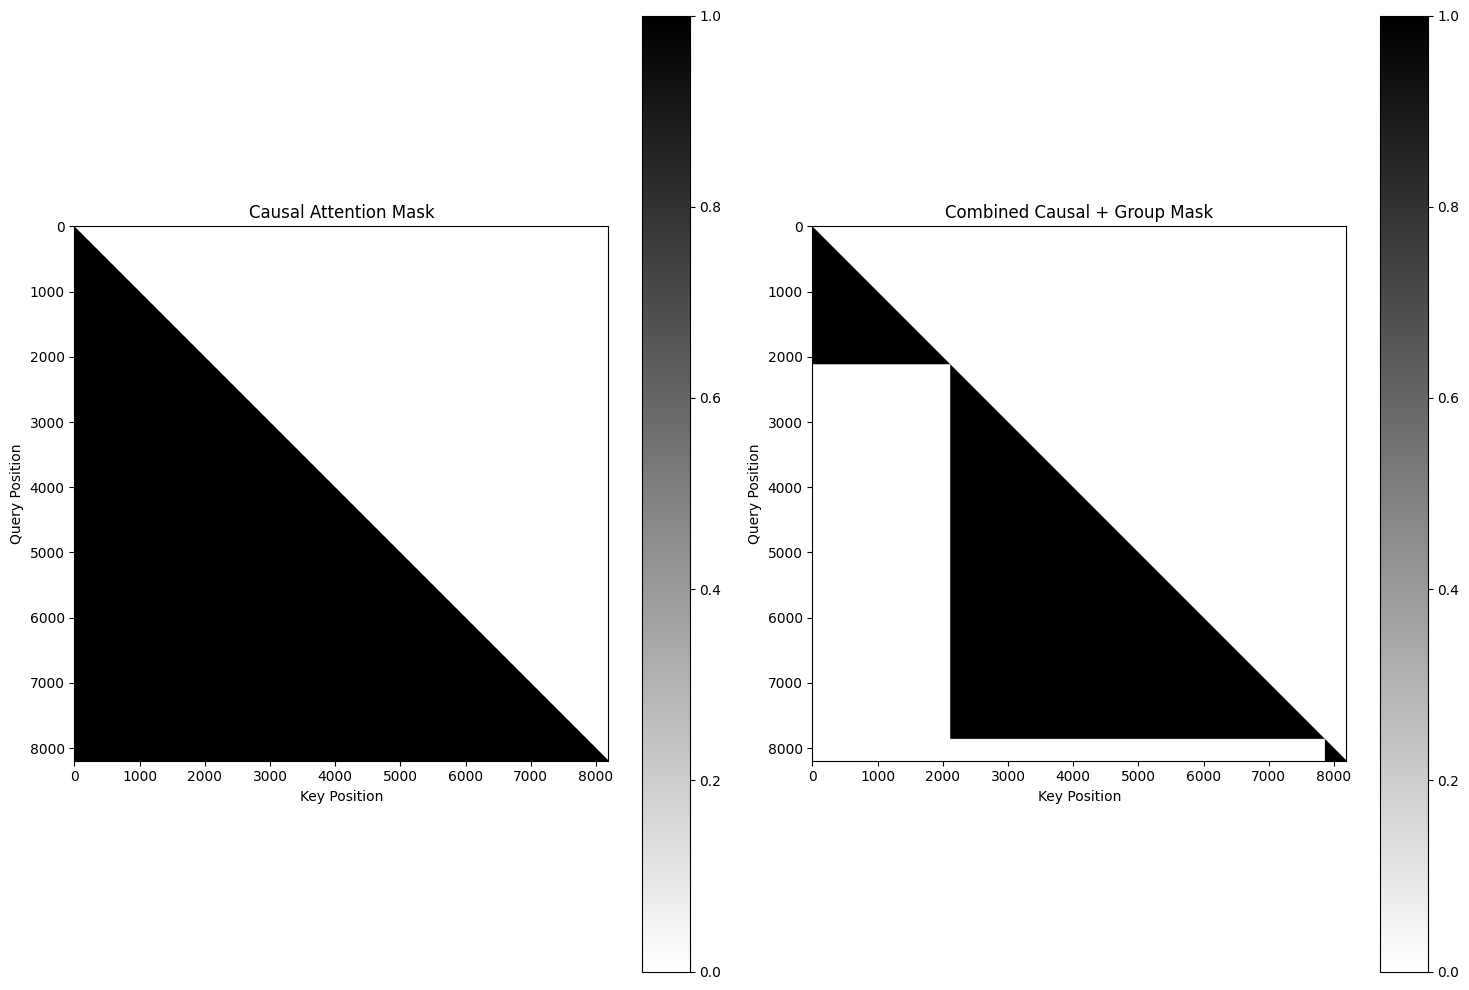

Mask shape: torch.Size([63, 8192, 8192])
Number of allowed attention connections (True values): 1263707944
Percentage of allowed connections: 29.9%


In [10]:
import torch

shape = packed_tensors["tokens"].shape

# Create causal attention mask for the batch size and sequence length
batch_size = shape[0]
seq_length = shape[1]

causal_mask = (
    torch.tril(torch.ones(seq_length, seq_length, dtype=torch.bool))
    .unsqueeze(0)
    .expand(batch_size, seq_length, seq_length)
)
group_mask = packed_tensors["group_ids"].unsqueeze(2) == packed_tensors[
    "group_ids"
].unsqueeze(1)
final_mask = causal_mask & group_mask

# Verify mask shape matches batch size and sequence length
print(f"Final mask shape: {final_mask.shape}")

# Visualize the combined attention mask
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Plot causal mask
mask_example = causal_mask[0].cpu().numpy()
im1 = ax1.imshow(mask_example, cmap="binary")
ax1.set_title("Causal Attention Mask")
ax1.set_xlabel("Key Position")
ax1.set_ylabel("Query Position")
plt.colorbar(im1, ax=ax1)

# Plot combined mask
final_mask_example = final_mask[0].cpu().numpy()
im2 = ax2.imshow(final_mask_example, cmap="binary")
ax2.set_title("Combined Causal + Group Mask")
ax2.set_xlabel("Key Position")
ax2.set_ylabel("Query Position")
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Mask shape: {final_mask.shape}")
print(
    f"Number of allowed attention connections (True values): {final_mask.sum().item()}"
)
print(
    f"Percentage of allowed connections: {final_mask.sum().item() / (final_mask.numel()) * 100:.1f}%"
)